note : RPN is just for classifying whether there is an object or background and also proposing a bounding box if object is present. It does not classify between vehicle, person or animal.

## Imports, Mount Drive, Set CUDA, Global Variables

In [1]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pad, normalize, resize
import matplotlib.patches as patches
import os
from  matplotlib.patches import Rectangle as rec
from torch import nn, Tensor
from torchvision.ops import box_iou
import random
from copy import deepcopy
from tqdm import tqdm

!pip install pytorch_lightning &> /dev/null
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [4]:
h_img = 800
w_img = 1088
debug = False

## BuildDataset class

In [5]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.images_path = os.path.join(path[0])  
        self.masks_path = os.path.join(path[1])    
        self.labels_path = os.path.join(path[2])
        self.bboxes_path = os.path.join(path[3])
        self.images = np.array(h5py.File(self.images_path, 'r')['data'])    #transformation needed : 0-1, resize, normalize, pad
        self.masks = np.array(h5py.File(self.masks_path, 'r')['data'])      #transformation needed : resize, pad
        self.bboxes = np.load(self.bboxes_path, allow_pickle=True, encoding='latin1')    #transformation needed : scaling and add padding
        self.labels = np.load(self.labels_path, allow_pickle=True, encoding='latin1')
        self.indexes = []
        temp = 0
        for i in range(len(self.images)):
          self.indexes.append(temp)
          temp += self.labels[i].shape[0]
          
        self.indexes = np.array(self.indexes)

    def __getitem__(self, index):
        #example : images[5] has 2 objects in it; so there will be 2 labels, 2 corresponding masks and 2 corresponding bounding boxes
        image = torch.from_numpy(self.images[index].astype('float32')).to(device)                                               #previously was uint32
        labels = torch.from_numpy(self.labels[index]).to(device)                                                                #int64
        n_obj = labels.shape[0]                  #number of objects present in the image
        masks = torch.from_numpy(self.masks[self.indexes[index] : self.indexes[index] + n_obj].astype('float32')).to(device)    #previously was uint32
        bboxes = torch.from_numpy(self.bboxes[index]).to(device)                                                                #float32  
        transed_img, transed_masks, transed_bboxes = self.pre_process_single(image, masks, bboxes)
        return transed_img, labels, transed_masks, transed_bboxes, index

    #the 3 transformations below are defined for single image and its corresponding (sometimes multiple) masks and bounding boxes
    def pre_process_single(self, image, masks, bboxes):   
        #img transformation : 0-1, resize, normalize, pad
        img = pad(normalize(resize(torch.div(image, 255), size=(800,1066)), (0.485,0.456,0.406), (0.229,0.224,0.225)), [11,0])
        #mask transformation : resize, pad
        new_masks = pad(resize(masks, size=(800,1066)), [11,0])
        #bounding boxes transformation : scaling and pad
        old_h = 300
        old_w = 400
        new_h = 800
        new_w = 1066
        padding = 22
        scale_x = new_w/old_w
        scale_y = new_h/old_h
        new_bboxes = torch.zeros_like(bboxes)
        new_bboxes[:,0] = scale_x * bboxes[:,0] - padding/2
        new_bboxes[:,1] = scale_y * bboxes[:,1]
        new_bboxes[:,2] = scale_x * bboxes[:,2] + padding/2
        new_bboxes[:,3] = scale_y * bboxes[:,3]

        return img, new_masks, new_bboxes
       
    def __len__(self):
        return len(self.images)

    def preprocess_visualize(self, index):
        transed_img, labels, transed_masks, transed_bboxes, _ = self.__getitem__(index)
        fig = plt.figure()
        ax = fig.add_subplot()
        
        image = torch.permute(transed_img, (1,2,0))
        image = image.cpu().detach().numpy()
        ax.imshow(image)
        masked_img = np.zeros_like(image)

        for n, mask in enumerate(transed_masks):
          mask = mask.cpu().detach().numpy()
          three_mask = np.stack((mask, mask, mask), axis=2)

          red, green, blue = np.zeros_like(three_mask), np.zeros_like(three_mask), np.zeros_like(three_mask)

          red[:] = (255 , 0 , 0)
          green[:] = (0 , 255 , 0)
          blue[:] = (0 , 0 , 255)
          mask_colours = {1:red, 2:green, 3:blue}   #vehicle : red, human : green, animal : blue
          colour_idx = labels.cpu().detach().numpy()
          masked_img = np.where(three_mask != 0 , mask_colours[colour_idx[n]], image)
          ax.imshow(masked_img, alpha = 0.4)  
        
        for n, bbox in enumerate(transed_bboxes):
          xy = (bbox[0].cpu().detach().numpy(), bbox[1].cpu().detach().numpy()) 
          w = bbox[2] - bbox[0]
          h = bbox[3] - bbox[1]
          w = w.cpu().detach().numpy()
          h = h.cpu().detach().numpy()
          colours = {1:'r', 2:'g', 3: 'b'}
          colour_idx = labels.cpu().detach().numpy()
          ax.add_patch(rec(xy, w, h , edgecolor=colours[colour_idx[n]], facecolor='none'))

In [6]:
imgs_path = 'drive/MyDrive/CIS680/HW4/images.h5'
masks_path = 'drive/MyDrive/CIS680/HW4/masks.h5'
labels_path = 'drive/MyDrive/CIS680/HW4/labels.npy'
bboxes_path = 'drive/MyDrive/CIS680/HW4/bboxes.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
dataset = BuildDataset(paths)

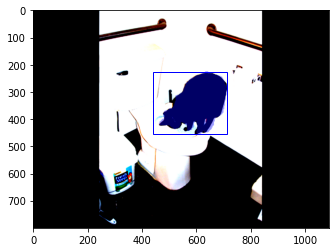

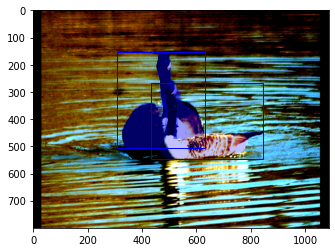

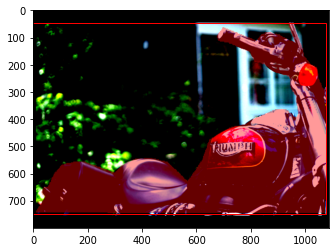

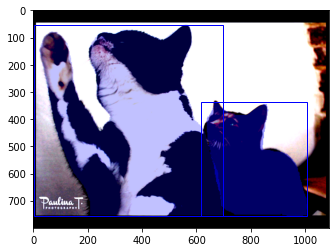

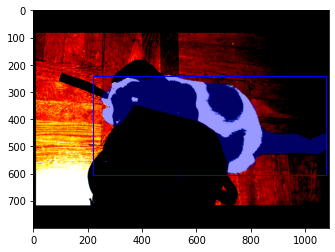

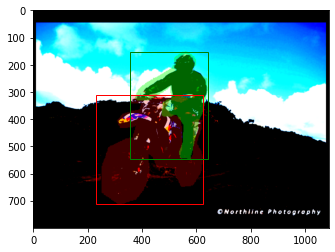

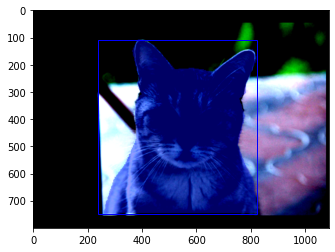

In [7]:
for i in range(7):
  dataset.preprocess_visualize(i)

## Aspect Ratio and Scale Selection

In [8]:
aspect_ratio = []
scale = []
for i in range(len(dataset)):
  _, _, _, bboxes, _ = dataset.__getitem__(i)
  for n, bbox in enumerate(bboxes):
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    ar = torch.div(w,h).cpu().detach().numpy()
    sc = torch.sqrt(torch.mul(w,h)).cpu().detach().numpy()
    aspect_ratio.append(ar)
    scale.append(sc)

best aspect ratio is: 0.6214793


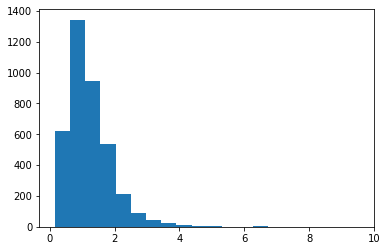

In [9]:
a = plt.hist(aspect_ratio, bins = 20)
best_aspect_ratio = a[1][np.argmax(a[0])]
print("best aspect ratio is:", best_aspect_ratio)

best scale is: 263.0991


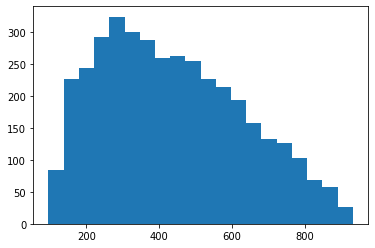

In [10]:
s = plt.hist(scale, bins=20)
best_scale = s[1][np.argmax(s[0])]
print("best scale is:", best_scale)

In [11]:
best_aspect_ratio = torch.as_tensor(best_aspect_ratio,dtype=torch.float32)
best_scale = torch.as_tensor(best_scale,dtype=torch.float32)

## Anchor Box Creation,  GT Creation, RPN Backbone, Heads, Losses

In [62]:
class RPNHead(nn.Module):

    def __init__(self,  device='cuda', anchors_param=dict(ratio=best_aspect_ratio, scale=best_scale, grid_size=(50, 68), stride=16)):
        # Initialize the backbone, intermediate layer clasifier and regressor heads of the RPN
        super(RPNHead,self).__init__()

        self.device=device
        # Define Backbone
        self.backbone = nn.Sequential(
                                        nn.Conv2d(in_channels=3 , out_channels= 16, kernel_size= 5, padding= 'same',) ,
                                        nn.BatchNorm2d(num_features=16) ,
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2,padding=0) , 

                                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same'),
                                        nn.BatchNorm2d(num_features=32) ,
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2,padding=0) ,

                                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'),
                                        nn.BatchNorm2d(num_features=64) ,
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2,padding=0) ,

                                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding='same'),
                                        nn.BatchNorm2d(num_features=128) ,
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2,padding=0) , 

                                        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding='same'),
                                        nn.BatchNorm2d(num_features=256) ,
                                        nn.ReLU()
                                    )

        # Define Intermediate Layer
        self.intermediate = nn.Sequential(
                                        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
                                        nn.BatchNorm2d(num_features=256) ,
                                        nn.ReLU()
                                        )

        # Define Proposal Classifier Head
        self.classifier = nn.Sequential(
                                        nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, padding='same'),
                                        nn.Sigmoid()
                                        )

        # Define Proposal Regressor Head
        self.regressor = nn.Sequential(
                                       nn.Conv2d(in_channels=256, out_channels=4, kernel_size=1, padding='same')
                                      )

        # find anchors
        self.anchors_param=anchors_param
        self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
        self.ground_dict={}
       
    '''
    Forward  the input through the backbone the intermediate layer and the RPN heads
    Input:
          X: (bz,3,H,W)
    Ouput:
          logits: (bz,1,Sy,Sx)
          bbox_regs: (bz,4,Sy,Sx)
    '''
    def forward(self, X):
        #forward through the backbone
        X = self.backbone(X)
        #forward through the Intermediate layer
        X = self.intermediate(X)
        #forward through the Classifier Head
        objectness = self.classifier(X)
        #forward through the Regressor Head
        bbox_regs = self.regressor(X)

        if debug == True:
          print(objectness.shape[1:4])
          print(bbox_regs.shape[1:4])

        return objectness, bbox_regs

    '''
    This function creates the anchor boxes for 1 image
    Output:
          anchors: (Sy,Sx,4)
    '''
    def create_anchors(self, aspect_ratio, scale, grid_sizes, stride):
        _x = torch.arange(start = int(stride/2), end = int(w_img + stride/2), step=stride) 
        _y = torch.arange(start = int(stride/2), end = int(h_img + stride/2), step=stride)
        cx_ab, cy_ab = torch.meshgrid(_x, _y)

        h_ab = torch.div(scale, torch.sqrt(aspect_ratio))
        w_ab = torch.mul(scale, torch.sqrt(aspect_ratio))

        anchors = torch.zeros((grid_sizes[0], grid_sizes[1], 4))    #(Sy, Sx, 4) anchors where each of the 4 channels are of the form (x,y,w,h)
        anchors[:, :, 0] = cx_ab.T
        anchors[:, : ,1] = cy_ab.T
        anchors[:, :, 2] = w_ab
        anchors[:, :, 3] = h_ab

        if debug == True:
          print(anchors.shape)

        return anchors
    
    #for 1 image
    def get_anchors(self):
        return self.anchors

    '''
    This function creates the ground truth for 1 image
    It also caches the ground truth for the image using its index
    Input:
          bboxes:      (n_obj,4)
          index:       scalar (the index of the image in the total dataset used for caching)
          grid_size:   tuple:len(2)
          anchors:     (grid_size[0],grid_size[1],4)
    Output:
          ground_class:  (1,grid_size[0],grid_size[1])
          ground_coord: (4,grid_size[0],grid_size[1])
    '''
    def create_ground_truth(self, bboxes, index, grid_size, anchors):
        #note : bboxes are the ground truth in x1,y1,x2,y2 format
        #note : prefer doing calc in flattened mode
        bboxes = bboxes.to(device)
        anchors = anchors.to(device)
        flat_anchors = anchors.permute(2,0,1).flatten(start_dim=1,end_dim=-1).T
        x1=flat_anchors[:,0]-flat_anchors[:,2]/2.0
        y1=flat_anchors[:,1]-flat_anchors[:,3]/2.0
        x2=flat_anchors[:,0]+flat_anchors[:,2]/2.0
        y2=flat_anchors[:,1]+flat_anchors[:,3]/2.0
        # convert flattened anchors from x,y,w,h to x1,y1,x2,y2 format
        formated_flat_anchors = torch.hstack((x1.reshape(-1,1),y1.reshape(-1,1),x2.reshape(-1,1),y2.reshape(-1,1)))

        ground_coord = torch.zeros((grid_size[0]*grid_size[1],4)).to(device)
        ground_class = -1*torch.ones(grid_size[0]*grid_size[1]).to(device)

        # calculating IOU with all anchors (even the ones that are out of the image boundaries)
        iou = box_iou(formated_flat_anchors,bboxes)

        # convert bboxes from x1,y1,x2,y2 to x,y,w,h format so that we can encode them
        x = (bboxes[:,0]+bboxes[:,2])/2.0
        y = (bboxes[:,1]+bboxes[:,3])/2.0
        w = (bboxes[:,2]-bboxes[:,0])
        h = (bboxes[:,3]-bboxes[:,1])
        formated_bboxes = torch.hstack((x.reshape(-1,1),y.reshape(-1,1),w.reshape(-1,1),h.reshape(-1,1)))

        # FINDING POSITIVE LABELS and corresponding ground truth bboxes
        pos_idx_mask = torch.max(iou,dim=1)[0]>=0.7
        pos_idx = pos_idx_mask.nonzero().flatten()
        ground_class[pos_idx] = 1
        # finding corresponding bbox and anchor info
        bbox_index = torch.max(iou,dim=1)[1]
        bbox_label = bbox_index[pos_idx]
        anchor_data = flat_anchors[pos_idx]
        xa = anchor_data[:,0]
        ya = anchor_data[:,1]
        wa = anchor_data[:,2]
        ha = anchor_data[:,3]
        # encoding to tx, ty, tw, th
        ground_coord[pos_idx,0]= (formated_bboxes[bbox_label,0]-xa)/wa
        ground_coord[pos_idx,1]= (formated_bboxes[bbox_label,1]-ya)/ha
        ground_coord[pos_idx,2]= torch.log(formated_bboxes[bbox_label,2]/wa)
        ground_coord[pos_idx,3]= torch.log(formated_bboxes[bbox_label,3]/ha)

        # FINDING IN BETWEEN LABELS and corresponding ground truth bboxes
        in_between = torch.logical_and(torch.max(iou,dim=1)[0]<0.7,torch.max(iou,dim=1)[0]>0.4)
        in_between_idx = in_between.nonzero().flatten()
        ground_class[in_between_idx] = 1
        # finding corresponding bbox and anchor info
        bbox_label = bbox_index[in_between_idx]
        anchor_data = flat_anchors[in_between_idx]
        xa = anchor_data[:,0]
        ya = anchor_data[:,1]
        wa = anchor_data[:,2]
        ha = anchor_data[:,3]
        # encoding to tx, ty, tw, th
        ground_coord[in_between_idx,0]= (formated_bboxes[bbox_label,0]-xa)/wa
        ground_coord[in_between_idx,1]= (formated_bboxes[bbox_label,1]-ya)/ha
        ground_coord[in_between_idx,2]= torch.log(formated_bboxes[bbox_label,2]/wa)
        ground_coord[in_between_idx,3]= torch.log(formated_bboxes[bbox_label,3]/ha)

        # FINDING NEGATIVE LABELS (they don't have any ground truth boxes attached)
        ground_class[torch.all(iou<=0.3,dim=1)]=0

        #ELIMINATING CROSS BOUNDARY ANCHORS
        cross_bound_l = torch.logical_or(x1<=0,y1<=0)
        cross_bound_h = torch.logical_or(x2>=1088.0,y2>=800)
        ground_class[cross_bound_l]=-1
        ground_class[cross_bound_h]=-1

        ground_class = ground_class.unsqueeze(dim=0).reshape(1,grid_size[0],grid_size[1])
        ground_coord = ground_coord.T.reshape(4,grid_size[0],grid_size[1])

        #caching
        key = str(index)
        if key in self.ground_dict:
            groundt, ground_coord = self.ground_dict[key]
            return groundt, ground_coord

        self.ground_dict[key] = (ground_class, ground_coord)

        return ground_class, ground_coord

    '''
    Function calls create_ground_truth internally for multiple images in the batch
    input : list: len(bz) (n_obj,4)
            indexes : list: len(bz)
    output : ground_class_batch : (bz,1,grid_size[0], grid_size[1])
             ground_coord_batch : (bz,4,grid_size[0], grid_size[1])
    '''
    def create_batch_truth(self, bboxes_list, indexes_list):
        ground_class_list=[]
        ground_coord_list=[]
        for idx in range(len(bboxes_list)):
          ground_class, ground_coord = self.create_ground_truth(bboxes_list[idx], indexes_list[idx], (self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1]), self.anchors)
          ground_class_list.append(ground_class)
          ground_coord_list.append(ground_coord)
        
        ground_class_batch = torch.stack(ground_class_list)
        ground_coord_batch = torch.stack(ground_coord_list)

        if debug == True:
          print(ground_class_batch.shape[1:4])
          print(ground_coord_batch.shape[1:4])

        return ground_class_batch, ground_coord_batch   

    '''
    Compute the loss of the classifier
    '''
    def loss_class(self, pos_class_gt, pos_class_pred, neg_class_gt, neg_class_pred, pos_anchors, neg_anchors):
        skip_flag_pos = False
        skip_flag_neg = False
        if (pos_anchors.shape[0]==0):
          skip_flag_pos = True
        if (neg_anchors.shape[0]==0):
          skip_flag_neg = True
        criterion = torch.nn.BCELoss()
        #seperately calc postiive class and negative class loss:
        neg_class_loss = criterion(neg_class_pred+1e-10,neg_class_gt) if skip_flag_neg == False else torch.tensor(0)
        pos_class_loss = criterion(pos_class_pred+1e-10, pos_class_gt) if skip_flag_pos == False else torch.tensor(0)
        loss_c = neg_class_loss + pos_class_loss
        #print(loss_c)
        return loss_c
   
    '''
    Compute the loss of the regressor
    '''
    def loss_reg(self, pos_regr_gt, pos_regr_pred):
        criterion = nn.SmoothL1Loss()
        loss_r = sum([criterion(pos_regr_gt[i], pos_regr_pred[i]) for i in range(4)])
        print(loss_r)
        return loss_r

    '''
    Compute the total loss
    Input:
          class_out: (bz,1,grid_size[0],grid_size[1]) #preds
          regr_out: (bz,4,grid_size[0],grid_size[1])  #preds
          targ_class:(bz,1,grid_size[0],grid_size[1]) #gt
          targ_regr:(bz,4,grid_size[0],grid_size[1])  #gt
          l: lambda constant to weight between the two losses
          effective_batch: the number of anchors in the effective batch (M in the handout)
    '''
    def compute_loss(self, class_out, regr_out, targ_class, targ_regr, l=1, effective_batch=50):
        #step 1: flatten the class_out and targ_class
        targ_class = targ_class.reshape(-1)
        class_out = class_out.reshape(-1)
        #step 2: create mini batch
        pos_anchors = (targ_class==1).nonzero()
        neg_anchors = (targ_class==0).nonzero()
        pos_size = int( min(pos_anchors.shape[0], effective_batch/2))
        neg_size = int(effective_batch - pos_size)
        pos_anchors = pos_anchors[torch.randperm(pos_anchors.shape[0]), :]
        pos_anchors = pos_anchors[:pos_size, :]
        neg_anchors = neg_anchors[torch.randperm(neg_anchors.shape[0]), :]
        neg_anchors = neg_anchors[:neg_size, :]
        #step 3: assign positive and negative ground truths and predictions for the classifier
        pos_class_gt = targ_class[pos_anchors]
        pos_class_pred = class_out[pos_anchors]
        neg_class_gt = targ_class[neg_anchors]
        neg_class_pred = class_out[neg_anchors]

        #step 4: calculate classifier loss for both positive and negative ground truth labels
        loss_c = self.loss_class(pos_class_gt, pos_class_pred, neg_class_gt, neg_class_pred, pos_anchors, neg_anchors)

        # step 5: calculate regressor loss for only positive ground truth labels
        #reshape the regressor outputs and targets from (bs, 4, Sy, Sx) to (4, bs, Sy, Sx)
        targ_regr = targ_regr.permute(1,0,2,3)
        regr_out = regr_out.permute(1,0,2,3)
        #flatten the regressor output and targets to (4, bs*Sy*Sx)
        targ_regr = targ_regr.reshape(4,-1)
        regr_out = regr_out.reshape(4,-1)
        #get only postive ground truth labels for the regressor
        pos_regr_gt = targ_regr[:, pos_anchors]
        pos_regr_pred = regr_out[:, pos_anchors]

        #call regressor loss
        loss_r = self.loss_reg(pos_regr_gt, pos_regr_pred)

        loss = loss_c + l * loss_r

        return loss, loss_c, loss_r

    '''
    Post process for the outputs for a batch of images
    Input:
          out_c:  (bz,1,grid_size[0],grid_size[1])}
          out_r:  (bz,4,grid_size[0],grid_size[1])}
          IOU_thresh: scalar that is the IOU threshold for the NMS
          keep_num_preNMS: number of masks we will keep from each image before the NMS
          keep_num_postNMS: number of masks we will keep from each image after the NMS
    Output:
          nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
          nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinates of the boxes that the NMS kept)
          clas_list : list:len(bz){(pre_NMS_boxes)} 
          prebox_lsit : list:len(bz){(pre_NMS_boxes,4)} 
    '''
    def postprocess(self,out_c, out_r, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=10):
        nms_class_list = []
        nms_box_list = []
        clas_list = []
        prebox_list = []
        for img_id in range(len(out_c)):  #iterate over full batch
          nms_class, nms_box, clas, prebox = self.postprocessImg(out_c[img_id], out_r[img_id], IOU_thresh, keep_num_preNMS, keep_num_postNMS)
          nms_class_list.append(nms_class)
          nms_box_list.append(nms_box)
          clas_list.append(clas)
          prebox_list.append(prebox)
        return nms_class_list, nms_box_list, clas_list, prebox_list

    '''
    Post process the output for one image
    Input:
         mat_clas: (1,grid_size[0],grid_size[1])}  (scores of the output boxes)
         mat_coord: (4,grid_size[0],grid_size[1])} (encoded coordinates of the output boxes)
    Output:

          nms_clas: (Post_NMS_boxes)
          nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)
          clas : (pre_nms_boxes)
          prebox : (pre_nms_boxes,4)
    '''
    def postprocessImg(self,mat_clas,mat_coord, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
        #decode mat_coord from tx, ty, tw, th to normal x,y,w,h 
        anchors = self.anchors.to(device)
        anchors = anchors.reshape(-1,4)   #flattening
        xa = anchors[:,0]
        ya = anchors[:,1]
        wa = anchors[:,2]
        ha = anchors[:,3]
        mat_coord = mat_coord.permute(1,2,0).reshape(-1,4)
        mat_clas = mat_clas.flatten()
        tx, ty, tw, th = mat_coord[:,0],  mat_coord[:,1], mat_coord[:,2], mat_coord[:,3]
        x, y, w, h = tx*wa+xa, ty*ha+ya, torch.exp(tw)*wa, torch.exp(th)*ha
        #convert to x1,y1,x2,y2 format
        x1, y1, x2, y2 = x- w/2, y-h/2, x+w/2, y+h/2
        #remove invalid upper and lower bounds
        cross_bound_l = torch.logical_or(x1<=0,y1<=0)
        cross_bound_h = torch.logical_or(x2>=1088.0,y2>=800)
        mat_clas[cross_bound_l]=0
        mat_clas[cross_bound_h]=0

        #take only the objectness that is >0.5
        thresh_obj = mat_clas[mat_clas>0.5]
        #take corresponding x1,y1,x2,y2
        x1, y1, x2, y2 = x1[mat_clas>0.5], y1[mat_clas>0.5], x2[mat_clas>0.5], y2[mat_clas>0.5]

        num_ele = min(keep_num_preNMS , len(thresh_obj))
        #take only top keep_num_preNMS boxes in sorted form to pass to nms
        id = torch.argsort(thresh_obj, descending=True)[:num_ele]
        prebox = torch.vstack((x1[id], y1[id], x2[id], y2[id]))
        clas = thresh_obj[id]
        # call NMS 
        post_nms_class, post_nms_bboxes = self.NMS(clas, prebox, IOU_thresh)
        post_nms_class = np.array(post_nms_class)
        post_nms_bboxes = np.array(post_nms_bboxes)
        keep = min(keep_num_postNMS, post_nms_class.shape[0])
        nms_clas = post_nms_class[:keep]
        nms_prebox = post_nms_bboxes[:keep]

        prebox = prebox.T.cpu().detach().numpy()
        clas = clas.cpu().detach().numpy()

        return nms_clas, nms_prebox, clas, prebox

    '''
    def NMS(self, clas, prebox, thresh):
    #Few notes :
    #check IoU within preds
    #make a clone of preds; don't modify inplace
    pred_clone = torch.clone(prebox)

    label = low_confidence_suppression(pred_clone) #discard all predictions with objectness<=0.5
    for i in range(label.shape[0]):    #repeat for all N preds
        for c in range(3):    #repeat for each class
          grid_coords = (torch.max(label[i,5:8,:,:],dim=0)[1] == c).nonzero() 
          for box1 in grid_coords:  #best_box
            c1 = label[i,0,box1[0],box1[1]] * label[i,5+c,box1[0],box1[1]]
            for box2 in grid_coords:  #other_boxes
              c2 = label[i,0,box2[0],box2[1]] * label[i,5+c,box2[0],box2[1]]
              confidence_score = box_iou(label[i, :, :, :], box1, box2) * label[i,0, box1[0], box1[1]]
              if(confidence_score >= 0.85):  #IoU_NMS is defined for each image (1, 8, 8, 8)
                #Supress the other strong overlaps
                label[i,0, box1[0], box1[1]] = 0
    return label
    '''

    '''
    Input  : clas:(top_k_boxes)
             prebox:(top_k_boxes,4)
    Output  :
    nms_clas : (remaining_boxes_after_nms)
    nms_prebox : (remaining_boxes_after_nms, 4)
    '''
    def NMS(self, clas, prebox, thresh):
        bbox_sorted=deepcopy(prebox.permute(1,0).detach().cpu())
        clas_sorted=deepcopy(clas.detach().cpu())
        nms_prebox=[]
        nms_clas=[]
        bbox_sorted=list(bbox_sorted.numpy())
        clas_sorted=list(clas_sorted.numpy())

        while len(bbox_sorted)!=0:
          curr_bbox=bbox_sorted[0]
          curr_conf=clas_sorted[0]
          bbox_sorted.remove(curr_bbox)
          clas_sorted.remove(curr_conf)
          nms_prebox.append(curr_bbox)
          nms_clas.append(curr_conf)
          for id,diff_boxes in enumerate(bbox_sorted):
            if(box_iou(torch.from_numpy(curr_bbox).reshape(1,4),torch.from_numpy(diff_boxes).reshape(1,4))[0]>0.5):
              del bbox_sorted[id]
              del clas_sorted[id]
        return nms_clas, nms_prebox

### Visualize GT (use only on CPU)

In [13]:
rpn = RPNHead()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
def visualize_gt(num_examples):
  bboxes_list = []
  indexes_list = []
  images_list = []

  for eg in range(num_examples):
    image, _, _, bboxes, index = dataset.__getitem__(eg)
    bboxes_list.append(bboxes)
    indexes_list.append(index)
    images_list.append(image)

  ground_class_batch, ground_coord_batch = rpn.create_batch_truth(bboxes_list, indexes_list)
  ground_class_batch = ground_class_batch
  ground_coord_batch = ground_coord_batch

  for idx in range(len(images_list)):
    #display original image
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(images_list[idx].detach().cpu().numpy().transpose(1,2,0))

    #obtain ground class and coordinates from the batch
    ground_class, ground_coord = ground_class_batch[idx],ground_coord_batch[idx]
    ground_class = ground_class
    ground_coord = ground_coord
    #prepare corresponding anchors 
    flat_anchors = rpn.get_anchors().permute(2,0,1).flatten(start_dim=1,end_dim=-1).T
    flat_ground_coord = ground_coord.flatten(start_dim=1,end_dim=-1)
    flat_ground_class = ground_class.reshape(-1)
    objects = (flat_ground_class==1).nonzero().flatten()
    #print(objects)

    #decoding object wise
    for elem in objects:
          x_a, y_a, w_a, h_a = flat_anchors[elem, 0], flat_anchors[elem, 1], flat_anchors[elem, 2], flat_anchors[elem, 3]
          tx, ty, tw, th = flat_ground_coord[0, elem], flat_ground_coord[1, elem], flat_ground_coord[2, elem], flat_ground_coord[3, elem]
          w = torch.exp(tw) * w_a
          h = torch.exp(th) * h_a
          x = (tx * w_a) + x_a
          y = (ty * h_a) + y_a
          rect = patches.Rectangle((x-w/2,y-h/2), w, h,fill=False,color='r')
          ax.add_patch(rect)
          rect = patches.Rectangle((x_a-w_a/2, y_a-h_a/2), w_a, h_a, fill=False,color='b')
          ax.add_patch(rect)
          
    plt.show()

In [15]:
#only runs on CPU
if device=='cpu':
  visualize_gt(20)

## BuildDataLoader class

In [63]:
#sanity check for training
# subset = []
# for i in range(15):
#   subset.append(dataset[i])

In [64]:
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [18]:
class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def collect_fn(self, batch):
        images, labels, masks, bounding_boxes, index = list(zip(*batch))
        return torch.stack(images), labels, masks, bounding_boxes, index

    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)

In [82]:
batch_size = 4
full_build_loader = BuildDataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
full_loader = full_build_loader.loader()
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

## Training

In [83]:
rpn_network_obj = RPNHead().to(device)
optimizer = torch.optim.Adam(rpn_network_obj.parameters(), lr = 0.001)

train_loss = []
train_loss_c = []
train_loss_r = []
val_loss = []
val_loss_c = []
val_loss_r = []
num_epochs = 20

for epoch in tqdm(range(num_epochs)):
  run_loss = 0
  run_loss_c = 0
  run_loss_r = 0
  #train the model
  rpn_network_obj.train()
  for i, (images, labels, masks, bboxes, indexes) in enumerate(train_loader):
    #pass it through the network
    clas, regr = rpn_network_obj.forward(images.to(device))
    #get gt
    gt_clas_batch, gt_coord_batch = rpn_network_obj.create_batch_truth(bboxes, indexes)
    #zero out optimizer
    optimizer.zero_grad()
    #calc the loss
    loss, loss_c , loss_r = rpn_network_obj.compute_loss(clas, regr, gt_clas_batch.to(device), gt_coord_batch.to(device))
    #backward pass
    loss.backward()
    optimizer.step()
    # empty intermediate predcitions 
    del clas, regr, gt_clas_batch, gt_coord_batch
    torch.cuda.empty_cache()

    run_loss += loss.item()
    run_loss_c += loss_c.item()
    run_loss_r += loss_r.item()

  train_loss.append(run_loss/len(full_loader))
  train_loss_c.append(run_loss_c/len(full_loader))
  train_loss_r.append(run_loss_r/len(full_loader))

  # checkpoint
  if(epoch%2==0):
    path = "/content/drive/MyDrive/CIS680/HW4/epoch" +str(epoch+1)
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': rpn_network_obj.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': run_loss/len(full_loader),
        'clas_loss': run_loss_c/len(full_loader),
        'regr_loss': run_loss_r/len(full_loader)
        }, path)
  
  #validating the model
  rpn_network_obj.eval()
  run_eval_loss = 0
  run_eval_loss_c = 0
  run_eval_loss_r = 0
  for j, (images, labels, masks, bboxes,indexes) in enumerate(test_loader):
    vclas, vregr = rpn_network_obj.forward(images.to(device))
    vgt_clas_batch, vgt_coord_batch=rpn_network_obj.create_batch_truth(bboxes,indexes)
    vloss, loss_cls , loss_re = rpn_network_obj.compute_loss(vclas, vregr, vgt_clas_batch.to(device), vgt_coord_batch.to(device))
    print(vloss.item())
    run_eval_loss += vloss.item()
    run_eval_loss_c += loss_cls.item()
    run_eval_loss_r += loss_re.item()
    del vclas, vregr, vgt_clas_batch, vgt_coord_batch
    torch.cuda.empty_cache()

  val_loss.append(run_eval_loss/len(full_loader))
  val_loss_c.append(run_eval_loss_c/len(full_loader))
  val_loss_r.append(run_eval_loss_r/len(full_loader))

  0%|          | 0/20 [00:00<?, ?it/s]

tensor(0.8055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2363, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 1/20 [00:00<00:13,  1.36it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(1.0857, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9039, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 2/20 [00:01<00:11,  1.59it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3709, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 3/20 [00:01<00:10,  1.59it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 4/20 [00:02<00:09,  1.67it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 5/20 [00:03<00:09,  1.63it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 6/20 [00:03<00:08,  1.69it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 7/20 [00:04<00:07,  1.65it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 8/20 [00:04<00:07,  1.69it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 10/20 [00:06<00:05,  1.70it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 11/20 [00:06<00:05,  1.64it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 12/20 [00:07<00:04,  1.68it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 13/20 [00:07<00:04,  1.65it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 15/20 [00:09<00:03,  1.65it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 16/20 [00:09<00:02,  1.69it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 17/20 [00:10<00:01,  1.66it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 18/20 [00:10<00:01,  1.69it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 19/20 [00:11<00:00,  1.66it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
nan


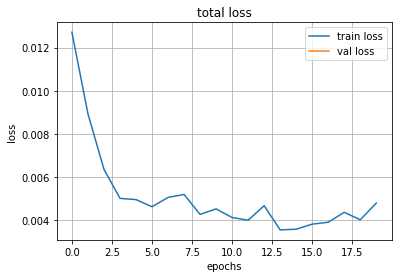

In [84]:
plt.plot(train_loss, label='train loss')
#plt.plot(val_loss, label='val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("total loss")
plt.legend()
plt.grid()
plt.show()

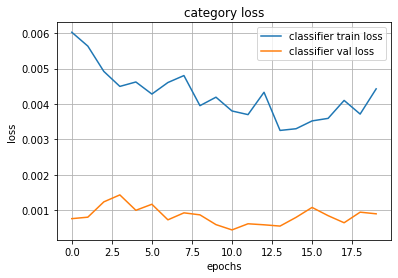

In [85]:
plt.plot(train_loss_c, label='classifier train loss')
plt.plot(val_loss_c, label='classifier val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("category loss")
plt.legend()
plt.grid()
plt.show()

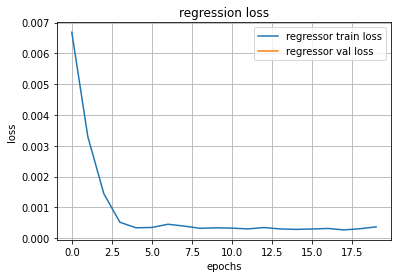

In [86]:
plt.plot(train_loss_r, label='regressor train loss')
#plt.plot(val_loss_r, label='regressor val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("regression loss")
plt.legend()
plt.grid()
plt.show()

## Post Processing

In [88]:
def visualize_post_process(boxes_list, images):
  for i in range(len(boxes_list)):    #number of examples to show
    fig = plt.figure()
    ax = fig.add_subplot()
    objs = boxes_list[i]
    ax.imshow(images[i].detach().cpu().numpy().transpose((1,2,0)))
    for box in objs:
      x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
      rect = rec((x1, y1), (x2 - x1), (y2 - y1), fill=False, color='r')
      ax.add_patch(rect)
  plt.show()

In [89]:
path = "/content/drive/MyDrive/CIS680/HW4/epoch19"
checkpoint = torch.load(path)
test_model = RPNHead().to(device)

test_model.load_state_dict(checkpoint['model_state_dict'])

#in eval mode
test_model.eval()
for idx, (images, labels, masks, bboxes, indexes) in enumerate(test_loader):
  clas, regr = test_model.forward(images) #predict
  post_nms_clas, post_nms_predbox, clas, prebox = test_model.postprocess(clas, regr)  #post process

Pre NMS


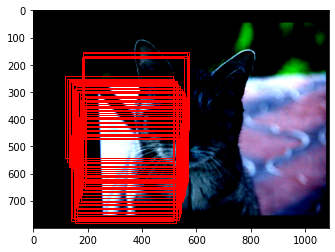

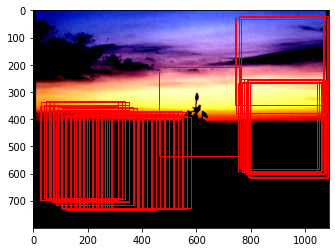

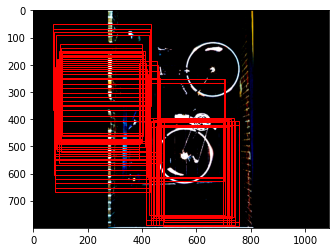

Post NMS


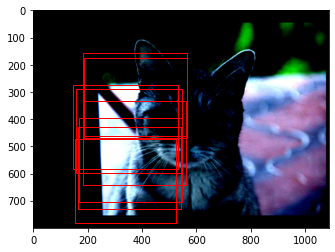

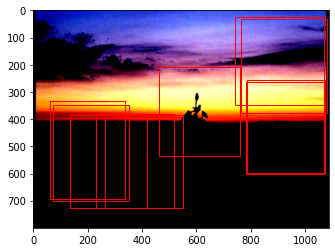

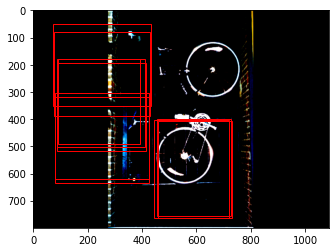

In [90]:
print("Pre NMS")
visualize_post_process(prebox,images)
print("Post NMS")
visualize_post_process(post_nms_predbox,images)

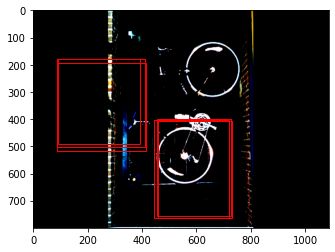

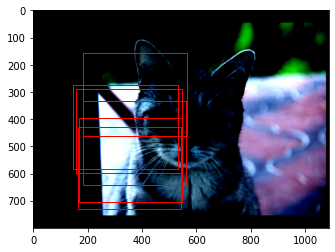

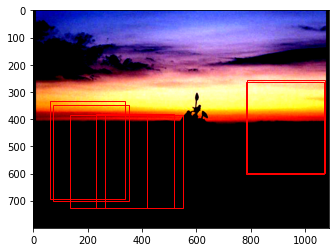

Point-wise Accuracy : 0.5480122324159021


In [91]:
length = 0
gt_equal_pred = 0
#It should be something like torch.sum(gt == pred)/(float(length)) in each batch and you accumulate them -TA

for idx, (images, labels, masks, bboxes, indexes) in enumerate(test_loader):
  clas, regr = test_model.forward(images)
  post_nms_clas, post_nms_bbox, pre_nms_class, pre_nms_bbox = test_model.postprocess(clas, regr,20,20)
  visualize_post_process(post_nms_bbox, images)
  # get batch truth only for classifier
  gt_clas_batch , _ = test_model.create_batch_truth(bboxes,indexes)
  # get total number of gt
  length += torch.sum(gt_clas_batch==1).item() + torch.sum(gt_clas_batch==0).item()
  #find correct predicitons for positive and negative labels
  pos_corr_pred = torch.sum(torch.logical_and(clas > 0.5, gt_clas_batch.to(device) == 1)).item()
  n_corr_pred = torch.sum(torch.logical_and(clas > 0.5, gt_clas_batch.to(device) == 0)).item()
  gt_equal_pred += pos_corr_pred + n_corr_pred

  torch.cuda.empty_cache()

pwa = gt_equal_pred/length
print("Point-wise Accuracy :", pwa) 